#  Radio Frequency Interference mitigation using deep convolutional neural networks

### This example demonstrates how tf_unet is trained on the 'Bleien Galactic Survey data'. 

To create the training data the SEEK package (https://github.com/cosmo-ethz/seek) has to be installed

In [1]:
from __future__ import division, print_function
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import glob
plt.rcParams['image.cmap'] = 'gist_earth'

## preparing training data
only one day...

In [2]:
!wget -q -r -nH -np --cut-dirs=2 https://people.phys.ethz.ch/~ipa/cosmo/bgs_example_data/

In [3]:
!mkdir -p bgs_example_data/seek_cache

In [5]:
!seek --file-prefix='./bgs_example_data' --post-processing-prefix='bgs_example_data/seek_cache' --chi-1=20 --overwrite=True seek.config.process_survey_fft

== Ivy run took:  57.897 s ===
Traversing file system        :   0.006s
Generate gain files           :   0.006s
Initialize                    :   0.000s
Load data                     :  14.805s
Convert TOD                   :   0.048s
Process coordinates           :   0.412s
Masking objects               :   0.671s
Masking artefacts             :   0.002s
Remove RFI                    :   9.661s
postprocessing TOD            :   0.045s
remove background baseline    :   0.524s
Restructure TOD               :   0.572s
ParallelPluginCollection      :  26.743s
Create maps                   :   1.681s
ParallelPluginCollection      :   1.760s
Write maps                    :   0.961s


## setting up the unet

In [2]:
from scripts.radio_util import DataProvider
from tf_unet import unet


In [3]:
files = glob.glob('bgs_example_data/seek_cache/*')

In [5]:
data_provider = DataProvider(600, files)

net = unet.Unet(channels=data_provider.channels, 
                n_class=data_provider.n_class, 
                layers=3, 
                features_root=64,
                cost_kwargs=dict(regularizer=0.001),
                )


2017-03-27 22:02:43,902 Layers 3, features 64, filter size 3x3, pool size: 2x2


Number of files used: 1


## training the network
only one epoch. For good results many more are neccessary

In [6]:

trainer = unet.Trainer(net, optimizer="momentum", opt_kwargs=dict(momentum=0.2))
path = trainer.train(data_provider, "./unet_trained_bgs_example_data", 
                     training_iters=32, 
                     epochs=1, 
                     dropout=0.5, 
                     display_step=2)



2017-03-27 22:02:51,017 Removing '/Users/jakeret/workspace/tf_unet/demo/prediction'
2017-03-27 22:02:51,020 Removing '/Users/jakeret/workspace/tf_unet/demo/unet_trained_bgs_example_data'
2017-03-27 22:02:51,020 Allocating '/Users/jakeret/workspace/tf_unet/demo/prediction'
2017-03-27 22:02:51,021 Allocating '/Users/jakeret/workspace/tf_unet/demo/unet_trained_bgs_example_data'
2017-03-27 22:03:14,962 Verification error= 28.9%, loss= 1.3888
2017-03-27 22:03:18,308 Start optimization
2017-03-27 22:03:32,717 Iter 0, Minibatch Loss= 1.3615, Training Accuracy= 0.6953, Minibatch error= 30.5%
2017-03-27 22:04:01,288 Iter 2, Minibatch Loss= 1.2693, Training Accuracy= 0.7771, Minibatch error= 22.3%
2017-03-27 22:04:31,532 Iter 4, Minibatch Loss= 1.3672, Training Accuracy= 0.7034, Minibatch error= 29.7%
2017-03-27 22:05:04,288 Iter 6, Minibatch Loss= 1.3466, Training Accuracy= 0.6975, Minibatch error= 30.2%
2017-03-27 22:05:32,188 Iter 8, Minibatch Loss= 1.4544, Training Accuracy= 0.4141, Minibatc

## running the prediction on the trained unet

In [10]:
data_provider = DataProvider(10000, files)
x_test, y_test = data_provider(1)
prediction = net.predict(path, x_test)

Number of files used: 1


2017-03-27 22:11:29,783 Model restored from file: ./unet_trained_bgs_example_data/model.ckpt


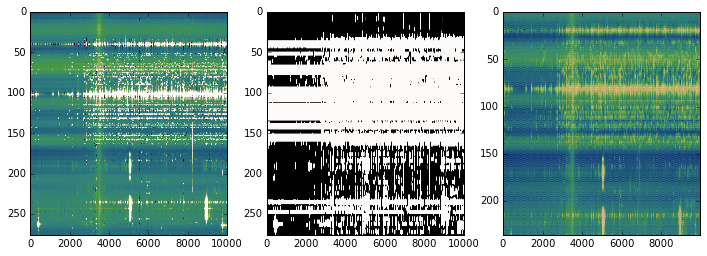

In [11]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")
ax[2].imshow(prediction[0,...,1], aspect="auto")